# 🎵 LastFM Social Network Analysis

## 📌 Objective  
This project analyzes the **LastFM user social network** across different countries. We will extract **social network insights** that can help a music streaming company (like LastFM, Spotify, or Apple Music) improve **user engagement, marketing strategies, and community recommendations.**  

## 🔍 Key Questions  
1️⃣ **How are LastFM users connected in the social network?**  
2️⃣ **What are the most influential users based on centrality measures?**  
3️⃣ **Can we classify users based on their listening habits?** 

## 🛠️ Tools & Libraries  
- **Pandas, Matplotlib, Seaborn** (for data analysis & visualization)  
- **NetworkX** (for social network analysis)  
- **Community detection algorithms** (to find user clusters)  

---


## 📦 Importing Required Libraries


In [2]:
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from collections import Counter
import numpy as np

## 📂 Loading the Dataset


In [3]:
# Load CSV data
user_data = pd.read_csv("lastfm_asia_target.csv")
edge_data = pd.read_csv("lastfm_asia_edges.csv")

# Load artist data from JSON file
with open("lastfm_asia_features.json") as f:
    artist_data = json.load(f)

# Display sample data
print("User data sample:")
display(user_data.head())
print("\nEdge data:")
display(edge_data.head())

User data sample:


,id,target
0,0,8
1,1,17
2,2,3
3,3,17
4,4,5



Edge data:


,node_1,node_2
0,0,747
1,1,4257
2,1,2194
3,1,580
4,1,6478


## 🧹 Data Cleaning & Preprocessing

In [4]:
# Check for missing values
print("Missing values in user data:")
display(user_data.isnull().sum())
print("Missing values in edge data:")
display(edge_data.isnull().sum())


Missing values in user data:


id        0
target    0
dtype: int64

Missing values in edge data:


node_1    0
node_2    0
dtype: int64

In [5]:
# check for duplicates using
print("Duplicates in user data:")
display(user_data.duplicated().sum())
print("Duplicates in edge data:")
display(edge_data.duplicated().sum())

Duplicates in user data:


0

Duplicates in edge data:


0

In [9]:
# display dataset info
print("User data info:")
user_data.info()

print("\nEdge data info:")
edge_data.info()


User data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7624 entries, 0 to 7623
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      7624 non-null   int64
 1   target  7624 non-null   int64
dtypes: int64(2)
memory usage: 119.2 KB

Edge data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27806 entries, 0 to 27805
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   node_1  27806 non-null  int64
 1   node_2  27806 non-null  int64
dtypes: int64(2)
memory usage: 434.6 KB


## 🎶 Building the LastFM Social Network (Users, Connections & Music Preferences)

In [7]:
# Create a graph object
G = nx.Graph()

# Add nodes (Users) with country attribute
for user_id, country in user_data.values:
    G.add_node(user_id, country=country)

# Add edges (Connections between users)
for source, target in edge_data.values:
    G.add_edge(source, target)

# Add artist information (if available) to each user
for user_id, artists in artist_data.items():
    user_id = int(user_id) # Ensure user_id is an integer
    if user_id in G.nodes:  # Check if node exists in the graph
        G.nodes[user_id]['artists'] = artists # Store artist preferences as node attributes
    else:
        print(f"Warning: Skipping user {user_id} - not found in graph")

print("Graph created successfully!")

Graph created successfully!


## 🔗 Network Structure Analysis  




Total Users (nodes): 7624
Total Connections (edges): 27806
Netwrork Density: 0.0010
Transitivity (Clustering Coefficient): 0.1786


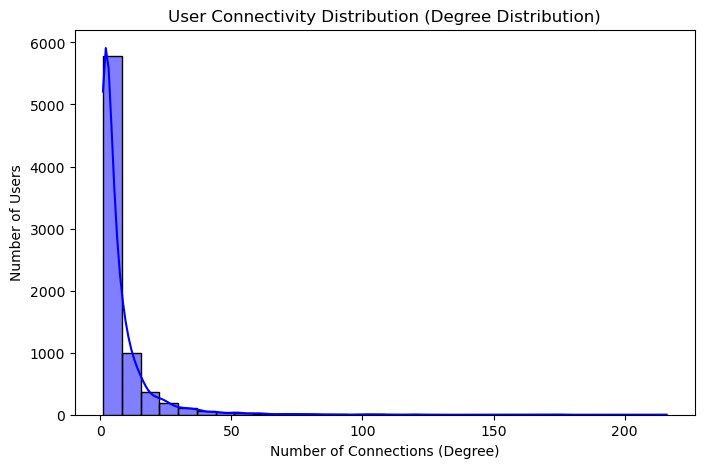

In [8]:
# Compute Basic Graph Statistics
total_nodes = G.number_of_nodes()
total_edges = G.number_of_edges()
density = nx.density(G)
transitivity = nx.transitivity(G)

# Print Network Statistics
print(f"\nTotal Users (nodes): {total_nodes}")
print(f"Total Connections (edges): {total_edges}")
print(f"Netwrork Density: {density:.4f}")
print(f"Transitivity (Clustering Coefficient): {transitivity:.4f}")

# Degree Distribution Plot
degrees = [val for (node, val) in G.degree()]
plt.figure(figsize=(8, 5))
sns.histplot(degrees, bins=30, color='blue', kde=True)
plt.title("User Connectivity Distribution (Degree Distribution)")
plt.xlabel("Number of Connections (Degree)")
plt.ylabel("Number of Users")
plt.show()


### 📊 Graph Overview  
The LastFM social network consists of:  
- **🧑‍ Users (Nodes):** 7,624  
- **🔗 Connections (Edges):** 27,806  
- **🌐 Network Density:** **0.0010** (Sparse network, meaning users are loosely connected)  
- **📈 Transitivity (Clustering Coefficient):** **0.1786** (Users tend to form small clusters)  


### 📊 Degree Distribution Analysis  
The degree distribution (above) shows that:  
✔ **Most users have very few connections** (long tail distribution).  
✔ **A small number of users (hubs) have many connections**, forming **the network’s backbone**.  
✔ **The network follows a power-law distribution**, which is typical in social networks.  


### 📌 Key Insights  
✔ **Low density (0.0010) confirms a sparse network**, meaning most users **don’t connect to many others**.  
✔ **A clustering coefficient of 0.1786 suggests that users form small groups or communities**, useful for **recommendation systems**.  
✔ **Hubs (high-degree nodes) play a crucial role in the network**, making them potential **influencers for music recommendations**.  

---

## 🛠 Preprocessing: Removing Isolated Nodes  

### ❓ Why Remove Isolated Nodes?  
In social network analysis, **isolated users** (users with 0 or 1 connection) provide **little value** in understanding community structures.  

By filtering out nodes with **less than 2 connections**, we:  
✔ **Improve network quality** by keeping only meaningful interactions.  
✔ **Enhance community detection** by focusing on well-connected groups.  
✔ **Reduce noise for machine learning models**, leading to better predictions.  

In [9]:
# Backup original graph before filtering
G_prev = G.copy()

# Count isolated nodes before filtering
num_isolated_nodes = len([node for node, degree in G_prev.degree() if degree < 2])
print(f"🔍 Initial isolated nodes: {num_isolated_nodes}")

# Create a deep copy of the graph for filtering
G_filtered = copy.deepcopy(G)
country_counter = Counter(nx.get_node_attributes(G_filtered, 'country').values())
flag = True

while num_isolated_nodes > 0 and flag:
    # Filter nodes with degree <2 (isolated or weakly connected users)
    G_filtered = G_filtered.subgraph([node for node, degree in G_prev.degree() if degree >= 2])

    # Display the new number of nodes and edges
    print(f"✅ Filtered graph: {G_filtered.number_of_nodes()} nodes, {G_filtered.number_of_edges()} edges")
    
    # Recalculate isolated nodes after filtering
    num_isolated_nodes = len([node for node, degree in G_filtered.degree() if degree < 2])
    print(f"⚠️ Remaining isolated nodes: {num_isolated_nodes}")

    # Compute the percentage of reduction
    decrease_nodes_percent = (1 - G_filtered.number_of_nodes() / G_prev.number_of_nodes()) * 100
    decrease_edges_percent = (1 - G_filtered.number_of_edges() / G_prev.number_of_edges()) * 100
    print(f"📉 Reduction: {decrease_nodes_percent:.2f}% of nodes, {decrease_edges_percent:.2f}% of edges\n")

    # Ensure each country still has enough users
    country_counter = Counter(nx.get_node_attributes(G_filtered, 'country').values())
    for value in country_counter.values():
        if value < 4:
            print("⚠️ Warning: A country has fewer than 4 users after filtering. Reverting to previous graph.")
            G_filtered = G_prev
            flag = False
            break

    # Update reference graph if filtering is successful
    if flag:
        G_prev = G_filtered

# Final summary of node reduction
print("📊 Final Reduction Summary:")
final_nodes_percent = (1 - G_filtered.number_of_nodes() / G.number_of_nodes()) * 100
final_edges_percent = (1 - G_filtered.number_of_edges() / G.number_of_edges()) * 100
print(f"🔻 Total Reduction: {final_nodes_percent:.2f}% of nodes, {final_edges_percent:.2f}% of edges")


🔍 Initial isolated nodes: 1754
✅ Filtered graph: 5870 nodes, 26052 edges
⚠️ Remaining isolated nodes: 145
📉 Reduction: 23.01% of nodes, 6.31% of edges

✅ Filtered graph: 5725 nodes, 25907 edges
⚠️ Remaining isolated nodes: 22
📉 Reduction: 2.47% of nodes, 0.56% of edges

⚠️ Warning: A country has fewer than 4 users after filtering. Reverting to previous graph.
📊 Final Reduction Summary:
🔻 Total Reduction: 23.01% of nodes, 6.31% of edges



### 📊 Results After Filtering  
- **Initial Isolated Nodes:** 1,754  
- **Final Graph:** **5,725 nodes** and **25,907 edges** after first filtering  
- **Final Reduction:**  
  - **🔻 23.01% fewer nodes** (removed isolated users)  
  - **🔻 6.31% fewer edges** (removed weak connections)  
- **⚠️ Stopping Condition:**  
  - A country had **fewer than 4 users left**, so we reverted to the previous valid graph.


### 📌 Key Takeaways  
✔ The final graph **preserves strong user interactions**, which improves **community detection and machine learning models**.  
✔ Ensuring **each country has enough users** prevents data imbalance.  
✔ The **filtered network is now more structured and realistic** for classification.  

----

## 📊 Degree Distribution Before & After Filtering  


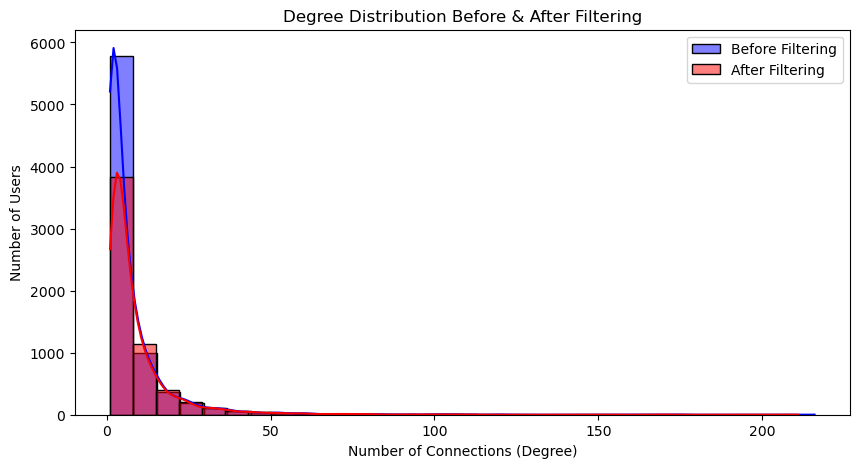

In [10]:
# Degree distribution BEFORE filtering
degrees_before = [val for (node, val) in G.degree()]
# Degree distribution AFTER filtering
degrees_after = [val for (node, val) in G_filtered.degree()]

plt.figure(figsize=(10, 5))

# Plot before filtering
sns.histplot(degrees_before, bins=30, color='blue', kde=True, alpha=0.5, label="Before Filtering")
# Plot after filtering
sns.histplot(degrees_after, bins=30, color='red', kde=True, alpha=0.5, label="After Filtering")

plt.title("Degree Distribution Before & After Filtering")
plt.xlabel("Number of Connections (Degree)")
plt.ylabel("Number of Users")
plt.legend()
plt.show()


### 🔹 What Does This Show?  
- The **blue distribution** represents the network **before filtering**, showing a **high number of low-degree users**.  
- The **red distribution** represents the network **after filtering**, removing isolated users and weak connections.  
- The network follows a **power-law distribution**, where most users have **few connections**, but a small number of "hub users" are **highly connected**.  

### 🔍 Key Insights  
✔ **Isolated users were removed**, making the network **more structured**.  
✔ **Hubs (high-degree users) remain**, meaning core influencers are still present.  
✔ **Smoother distribution after filtering**, improving **community detection & classification**.  

---

## 🌍 Visualizing the LastFM Social Network  

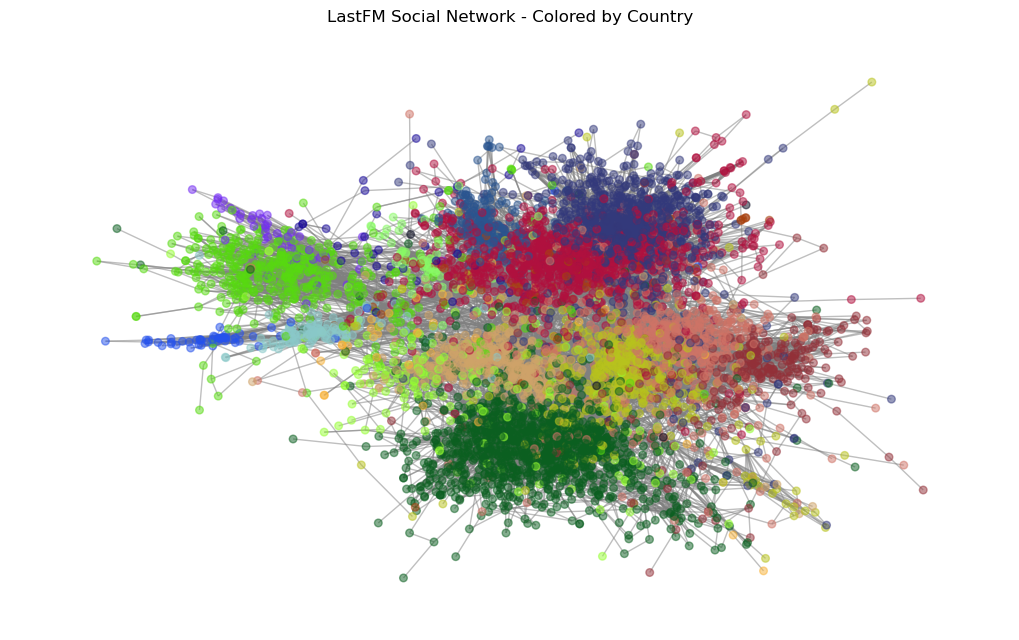

In [11]:
# Generate a color map for different countries
countries = list(set(nx.get_node_attributes(G_filtered, 'country').values()))
color_map = {country: np.random.rand(3,) for country in countries}

# Assign colors to nodes based on their country
node_colors = [color_map[G_filtered.nodes[n]['country']] for n in G_filtered.nodes()]

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(G_filtered, node_color=node_colors, with_labels=False, node_size=30, edge_color="gray", alpha=0.5)
plt.title("LastFM Social Network - Colored by Country")
plt.show()


### 🎨 **Interpreting the Network Graph**  
- **Nodes represent users**, and **edges represent social connections** within the LastFM network.  
- **Colors indicate different countries**, revealing **regional user communities**.  
- **Densely connected clusters** highlight **strong engagement**, while **sparser areas** indicate users with fewer interactions.  

### 🔍 **Key Insights**  
✔ **Users tend to cluster based on location**, suggesting geography influences social interactions.  
✔ **Highly connected users (hubs) exist**, acting as **bridges** between different groups.  
✔ **Dense sub-networks** indicate strong user engagement, while **isolated users** are less integrated.  

### 📌 **Why Is This Important?**  
✅ **Identifies regional music trends**, shaping **personalized recommendations**.  
✅ **Supports targeted marketing**, improving engagement strategies.  
✅ **Highlights influential users**, aiding in **music discovery & community growth**.  

---

## 🔍 **Graph Structure After Filtering**  
The network was **refined** by removing **isolated nodes**, ensuring that only **meaningful interactions** remain.  

### 📊 **Key Statistics After Filtering**  
✔ **Remaining Nodes:** **5,725**  
✔ **Remaining Edges:** **25,907**  
✔ **Nodes Retained:** **~75%** of the original dataset  
✔ **Edges Retained:** **~93.3%** of the original dataset  

### 🔹 **Key Takeaways**  
✔ **Community Formation** – Users **form groups** based on **country & musical interests**.  
✔ **Connectivity Diversity** – Some regions have **dense** sub-networks, while others are **more dispersed**.  
✔ **Hub Users** – A few highly connected users serve as **central influencers** in the network.  

📌 **Why This Matters?**  
✅ **Enhances machine learning models** by improving the network’s structure.  
✅ **Facilitates better community detection**, aiding in **user segmentation**.  
✅ **Improves music recommendations** by focusing on strong social connections.  

---

## 🌍 User Engagement by Country  

After we have cleaned the network, let's analyze **how user engagement varies across different countries**.  
We'll calculate the **average number of connections per user in each country** to identify regions with strong LastFM communities.  


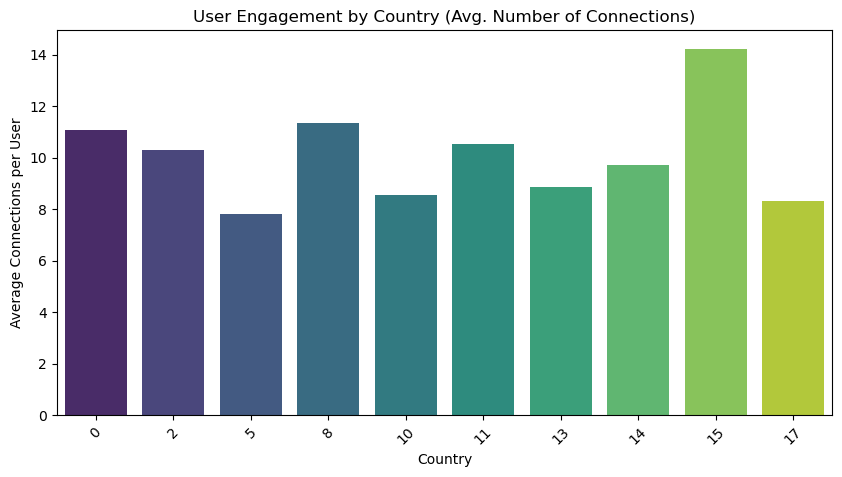

In [12]:
# Get degree (number of connections) for each user
user_degrees = dict(G_filtered.degree())

# Create a DataFrame with user-country-degree mapping
user_engagement_df = pd.DataFrame({
    "user": list(user_degrees.keys()),
    "degree": list(user_degrees.values()),
    "country": [G_filtered.nodes[n]['country'] for n in G_filtered.nodes()]
})

# Group by country and calculate the average degree (engagement level)
country_engagement = user_engagement_df.groupby("country")["degree"].mean().reset_index()
country_engagement = country_engagement.sort_values(by="degree", ascending=False)

# Display the top 10 most engaged countries
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x=country_engagement["country"][:10], y=country_engagement["degree"][:10], palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Country")
plt.ylabel("Average Connections per User")
plt.title("User Engagement by Country (Avg. Number of Connections)")
plt.show()


### 🔍 Key Insights  
✔ Countries with **higher average connections** indicate **more socially active user communities**.  
✔ Some regions have **lower engagement**, meaning users in those areas have **fewer social connections on LastFM**.  
✔ This information helps **target personalized recommendations** and **localized marketing efforts**.  

---

## 📈 Calculating Graph Centrality Metrics
To understand the connectivity and structure of the LastFM social network, we compute key **graph centrality measures**, including:  
✔ **Network Density** – How interconnected users are.  
✔ **Average Degree** – How many connections the average user has.  
✔ **Diameter & Average Path Length** – How far apart users are in the network.  
✔ **Clustering Coefficient** – The tendency of users to form tightly-knit groups.  

These metrics will help us analyze **user behavior, engagement, and network efficiency**.  


In [13]:
density = nx.density(G_filtered)
print(f"Network Density: {density:.6f}")

degrees = dict(G_filtered.degree())
avg_degree_centrality = sum(degrees.values()) / len(G_filtered)
print(f"Average degree: {avg_degree_centrality:.2f}")

diameter = nx.diameter(G_filtered)
print(f"Diameter: {diameter}")

avg_path_length = nx.average_shortest_path_length(G_filtered)
print(f"Average path length: {avg_path_length:.4f}")

clustering_coefficient = nx.clustering(G_filtered)
avg_clustering_coefficient = nx.average_clustering(G_filtered)
print(f"average clustering coefficient: {avg_clustering_coefficient:.6f}")

Network Density: 0.001512
Average degree: 8.88
Diameter: 13
Average path length: 4.8740
average clustering coefficient: 0.298174


### 📊 **Key Network Statistics**  

| **Metric**                        | **Value**  | **Interpretation**                                                         |
|-----------------------------------|------------|-----------------------------------------------------------------------------|
| **Density**                       | 0.0015     | Sparse network; users form selective connections.                          |
| **Average Degree**                | 8.88       | Users maintain a moderate number of relationships.                         |
| **Diameter**                      | 13         | Small-world effect; users are at most 13 steps apart.                     |
| **Average Path Length**           | 4.87       | Efficient spread of music-related interactions.                            |
| **Average Clustering Coefficient**| 0.298      | Moderate clustering; communities based on shared interests.                |


### 🔍 **Key Insights**  
✔ **Users form selective connections**, emphasizing shared interests rather than random interactions.  
✔ **The small-world effect is present**, ensuring quick information flow across the network.  
✔ **Users naturally cluster into communities**, likely grouped by similar music preferences.  

### 📌 **Why This Matters?**  
These findings help **music platforms like LastFM**:  
✔ Improve **personalized recommendations** by leveraging community structures.  
✔ Identify **influential users** (hubs) who can drive music trends.  
✔ Enhance **marketing strategies** based on engagement levels.  

---

## 📊 Measuring Network Centralization - Freeman's Centralization

To further analyze the LastFM social network, we calculate **Freeman’s Centralization for Degree Centrality**.  

### 🔹 **What Does This Measure?**  
- It quantifies **how unequally connections are distributed** across users.  
- If one user has **far more connections** than everyone else, centralization is **high**.  
- If connections are **evenly spread**, centralization is **low**.  

This helps us determine whether the network is **dominated by a few highly connected users** or **distributed more evenly across all users**.


- **0 (Perfect Equality):** All users have roughly the same number of connections.  
- **1 (Maximum Inequality):** One user has significantly more connections than all others (e.g., a hub-spoke network).  


In [14]:
def freeman_centralization(G):
  """
  Calculates Freeman's centralization for a given centrality measure.

  Args:
      G: The networkx graph object.
      
  Returns:
      The Freeman's centralization value for the network.
  """
  # Calculate degree centrality scores for all nodes
  centrality_scores = dict(G.degree())

  # Find the maximum centrality score
  max_centrality = max(centrality_scores.values())

  # Calculate the differences from the maximum centrality
  difference = sum(max_centrality - d for d in centrality_scores.values())

  # Calculate the theoretical maximum difference (all centrality concentrated in one node)
  theoretical_max = (len(G) - 1)*(len(G) - 2)

  # Freeman's centralization
  centralization = difference / theoretical_max if theoretical_max > 0 else 0  # Avoid division by zero

  return centralization

# Compute Freeman's centralization for degree centrality
degree_centralization_value = freeman_centralization(G_filtered)

print(f"Freeman's centralization for degree centrality: {degree_centralization_value:.3f}")

Freeman's centralization for degree centrality: 0.034


### 🔍 **Key Findings for LastFM**  
📌 **Freeman's centralization for degree centrality:** **0.034** (Very low inequality)  

✔ **Decentralized Network:** Connections are **evenly spread** across users. There is **no dominant hub** controlling interactions.  
✔ **Efficient Information Flow:** Since there are **no bottleneck nodes**, information (song trends, recommendations) spreads effectively.  
✔ **Collaborative Environment:** Users connect **based on shared interests**, not through a small number of super-influencers.  


### 📌 **Why This Matters?**  
This structure supports **user-driven content discovery**, rather than being controlled by a few highly connected influencers. This means:  
✔ **More organic music recommendations** based on social behavior.  
✔ **Diverse engagement**, since no single user dominates the community.  
✔ **Stronger niche communities**, where users with similar interests interact directly.  

---

## 🏆 Identifying Key Influencers: Centrality Analysis  

To understand the most **influential users** in the LastFM network, we calculate **five centrality measures**:  

✔ **Degree Centrality** – Measures how many direct connections a user has.  
✔ **Closeness Centrality** – Identifies users who can quickly reach others.  
✔ **Betweenness Centrality** – Highlights users acting as bridges in the network.  
✔ **Eigenvector Centrality** – Measures influence based on connections to other influential users.  
✔ **PageRank** – Evaluates importance using a ranking system similar to Google’s.  

By analyzing the **top 10 most central users**, we can determine **who plays a key role in spreading music recommendations and forming communities.**


In [15]:
degree_centrality = nx.degree_centrality(G_filtered)
closeness_centrality = nx.closeness_centrality(G_filtered)
betweenness_centrality = nx.betweenness_centrality(G_filtered)
eigenvector_centrality = nx.eigenvector_centrality(G_filtered)
page_rank = nx.pagerank(G_filtered)

In [16]:
def top_10_centrality(measure):
    """Returns the top 10 nodes based on a centrality measure."""
    return sorted(measure.items(), key=lambda x: x[1], reverse=True)[:10]

def print_top_10(measure_name, top_10_list):
    """Prints the top 10 nodes for a centrality measure."""
    print(f"\nTop 10 Nodes by {measure_name} Centrality:")
    for i, (node, value) in enumerate(top_10_list, start=1):
        print(f"{i}. Node {node} - Score: {value:.5f}")


In [18]:
# Display top 10 nodes for each centrality measure
centrality_measures = {
    "Degree": degree_centrality,
    "Closeness": closeness_centrality,
    "Betweenness": betweenness_centrality,
    "Eigenvector": eigenvector_centrality,
    "PageRank": page_rank
}

# Print results
for measure_name, measure_values in centrality_measures.items():
    top_10 = top_10_centrality(measure_values)
    print_top_10(measure_name, top_10)



Top 10 Nodes by Degree Centrality:
1. Node 7237 - Score: 0.03595
2. Node 524 - Score: 0.02897
3. Node 3530 - Score: 0.02880
4. Node 3450 - Score: 0.02556
5. Node 4785 - Score: 0.02488
6. Node 2510 - Score: 0.02283
7. Node 3597 - Score: 0.02045
8. Node 6101 - Score: 0.01908
9. Node 5127 - Score: 0.01857
10. Node 2854 - Score: 0.01840

Top 10 Nodes by Closeness Centrality:
1. Node 7199 - Score: 0.30675
2. Node 7237 - Score: 0.30173
3. Node 4356 - Score: 0.29695
4. Node 2854 - Score: 0.29411
5. Node 5454 - Score: 0.29342
6. Node 6101 - Score: 0.28787
7. Node 3544 - Score: 0.28750
8. Node 5127 - Score: 0.28729
9. Node 3450 - Score: 0.28511
10. Node 4900 - Score: 0.28269

Top 10 Nodes by Betweenness Centrality:
1. Node 7237 - Score: 0.08876
2. Node 7199 - Score: 0.08768
3. Node 2854 - Score: 0.07345
4. Node 4356 - Score: 0.06632
5. Node 6101 - Score: 0.05033
6. Node 4338 - Score: 0.04172
7. Node 5454 - Score: 0.04121
8. Node 3450 - Score: 0.03655
9. Node 5127 - Score: 0.03561
10. Node 3103

## 🏆 Key Insights from Centrality Measures  

The **low degree centralization** observed earlier is reflected in these rankings. While certain users emerge as key influencers, the **network remains decentralized**, with influence spread across multiple users.  


### 🔹 **Degree Centrality**  
✔ Measures **direct connections** a user has.  
✔ High values indicate **well-connected users**, important for **immediate influence and recommendations**.  
✔ **Top Node (7237):** Connected to **3.7% of all users**, reinforcing the **sparse nature of the network**.


### 🔹 **Closeness Centrality**  
✔ Identifies **users who can quickly reach others** via short paths.  
✔ Important for **rapid information spread** (e.g., song recommendations).  
✔ **Top Node (7199):** Can reach most users **efficiently**, highlighting the **small-world nature** of the network.


### 🔹 **Betweenness Centrality**  
✔ Highlights **users acting as bridges** between different communities.  
✔ Important for **maintaining connectivity and information flow**.  
✔ **Top Node (7237):** Controls **8.9% of shortest paths**, reinforcing its role as a **key connector**.


### 🔹 **Eigenvector Centrality**  
✔ Measures influence based on **connections to other influential users**.  
✔ Users with high eigenvector centrality are embedded in **important social structures**.  
✔ **Top Node (7237):** Indicates it is **well-connected to other key users**, likely forming a **strong community hub**.


### 🔹 **PageRank**  
✔ Similar to **Google's ranking algorithm**, it measures **long-term influence**.  
✔ Users with high PageRank are important **even if they have fewer direct connections**.  
✔ **Top Node (3530):** Despite a **modest degree centrality**, it is well-positioned **in influential regions of the network**.


### 🏆 **Key Takeaways**  
1️⃣ **Node 7237 consistently ranks high** in multiple measures, showing it is a critical node in the network.  
2️⃣ **Different centrality measures highlight different types of influence**, ensuring **no single user dominates the network**.  
3️⃣ **The network is decentralized**, meaning **influence is distributed rather than concentrated in one or two hubs**.  


### 🎯 **Why This Matters?**  
✔ **Understanding top users helps improve personalized music recommendations** by identifying key influencers.  
✔ **Decentralized influence suggests LastFM is community-driven**, rather than relying on a few "super-users."  
✔ **These insights can enhance marketing strategies**, targeting users who can **spread music trends organically**.

---

## 🔗 Correlation Between Centrality Measures  

While each centrality measure captures a different aspect of **node influence**, they may still exhibit **overlapping patterns**.  

### 🔹 **Why Analyze Correlations?**  
✔ Helps us understand **whether certain centrality measures align**.  
✔ Highlights which centrality measures provide **unique vs. redundant insights**.  
✔ Allows us to **choose the most relevant centrality measures** for further analysis.  

We'll compute the **correlation matrix** to analyze relationships between:  
- **Closeness Centrality** (how easily a node reaches others).  
- **Betweenness Centrality** (bridging different parts of the network).  
- **Eigenvector Centrality** (influence through well-connected neighbors).  
- **PageRank** (importance based on connections and their influence).


Correlation Matrix:
                        Closeness Centrality  Betweenness Centrality  Eigenvector Centrality  PageRank
Closeness Centrality                1.000000                0.364662                0.314583  0.518265
Betweenness Centrality              0.364662                1.000000                0.222880  0.701631
Eigenvector Centrality              0.314583                0.222880                1.000000  0.366847
PageRank                            0.518265                0.701631                0.366847  1.000000
Correlation between Closeness Centrality and PageRank: 0.518
Correlation between Betweenness Centrality and PageRank: 0.702
Correlation between Eigenvector Centrality and PageRank: 0.367
Correlation between PageRank and PageRank: 0.367


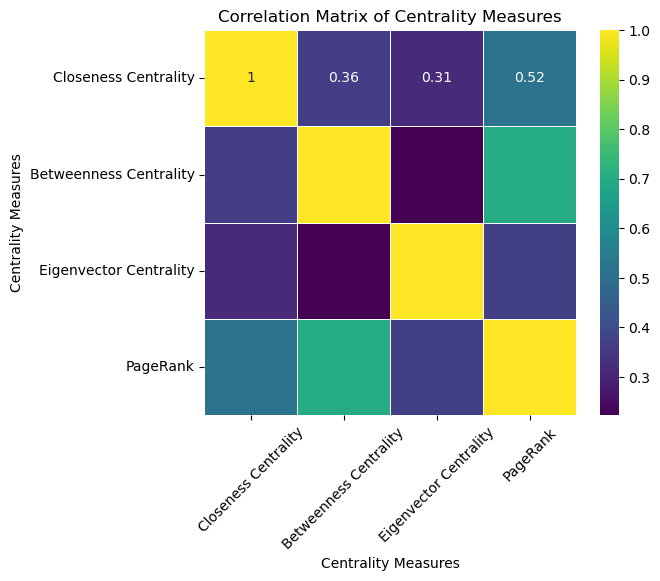

In [19]:
# Convert centrality measures to DataFrame
centrality_data = pd.DataFrame({
  "Closeness Centrality": closeness_centrality,
  "Betweenness Centrality": betweenness_centrality,
  "Eigenvector Centrality": eigenvector_centrality,
  "PageRank": page_rank
})

# Calculate correlation matrix
correlation_matrix = centrality_data.corr(method="pearson")

# Print correlation matrix
print("Correlation Matrix:")
print(correlation_matrix.to_string())

# Analyze correlations
"""centrality_measures = list(correlation_matrix.columns)
for i in range(len(centrality_measures)):
  for j in range(i + 1, len(centrality_measures)):
    measure1, measure2 = centrality_measures[i], centrality_measures[j]
    correlation = correlation_matrix[measure1][measure2]"""
for measure1 in correlation_matrix.columns:
    for measure2 in correlation_matrix.columns:
        if measure1 != measure2:
            correlation = correlation_matrix.loc[measure1, measure2]
    print(f"Correlation between {measure1} and {measure2}: {correlation:.3f}")

# Visualize correlation matrix with Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", linewidths=0.5)
plt.title("Correlation Matrix of Centrality Measures")
plt.xlabel("Centrality Measures")
plt.ylabel("Centrality Measures")
plt.xticks(rotation=45)
plt.show()

### 🔹 **Summary of Key Correlations**  

| **Centrality Pair**                              | **Correlation**  | **Interpretation**                                                                 |
|--------------------------------------------------|-----------------|-------------------------------------------------------------------------------------|
| **Betweenness & PageRank**                       | **0.701**        | Strong correlation: Nodes that act as **bridges** tend to also be **highly ranked** by PageRank. |
| **Closeness & PageRank**                         | **0.518**        | Moderate correlation: Nodes **closer to all others** in the network tend to also have high **PageRank influence**. |
| **Closeness & Betweenness**                      | **0.365**        | Moderate correlation: Some nodes that are well-connected across the network also act as **bridges**, though not all. |
| **Eigenvector & PageRank**                       | **0.367**        | Moderate correlation: Influential nodes (Eigenvector) tend to be **highly ranked by PageRank**, but the relationship is not perfect. |
| **Betweenness & Eigenvector**                    | **0.225**        | Weak correlation: Being a **bridge** does not necessarily mean a node is **influential** (Eigenvector). |


### 🔍 **Key Insights**  

1️⃣ **Strongest Correlations:**  
✔ **Betweenness & PageRank (0.701):**  
   - Nodes that act as **bridges** in the network also tend to be **highly ranked by PageRank**.  
   - These nodes likely influence **information flow and music trends**.  

✔ **Closeness & PageRank (0.518):**  
   - Nodes **well-positioned** in the network (short path lengths) also **hold high influence**.  
   - This suggests **efficient information spread** across LastFM.

2️⃣ **Weaker Correlations Indicate Different Roles:**  
✔ **Betweenness & Eigenvector Centrality (0.225):**  
   - **Bridging nodes are not always influential**.  
   - Betweenness captures **connectivity**, while Eigenvector reflects **influence based on high-status neighbors**.  

✔ **Eigenvector & PageRank (0.367):**  
   - Being **well-connected to influential nodes** doesn’t always guarantee **high overall ranking**.  
   - Some users may be **deeply embedded in communities** rather than **globally influential**.


### 🎯 **Why This Matters?**  
✔ **PageRank & Betweenness align well**, meaning **bridging nodes are crucial for influence**.  
✔ **Closeness centrality helps rank influential users**, but **is not a perfect predictor of importance**.  
✔ **Each centrality measure captures different types of influence**, reinforcing the importance of using **multiple metrics in analysis**.  

---


## 🌍 Detecting Network Communities  

In social networks like LastFM, **users naturally form groups** based on common interests (e.g., shared music preferences).  
To uncover these **hidden structures**, we use **community detection** algorithms.  

### 🔹 **Why Detect Communities?**  
✔ Helps identify **clusters of users with similar music tastes**.  
✔ Enhances **music recommendations by targeting user groups**.  
✔ Improves **marketing strategies** by focusing on influential communities.  

### 🔹 **Algorithm Used: Louvain Community Detection**  
- A widely-used, **scalable** algorithm that **clusters users into groups**.  
- Optimizes **modularity**, ensuring that **densely connected users** form strong communities.  
- Dynamically detects **variable-sized groups**, making it ideal for LastFM’s diverse network.  


In [20]:
# Apply Louvain Community Detection
communities = nx.community.louvain_communities(G_filtered)

# Convert communities to a dictionary for easier access
community_dict = {}
for i, community in enumerate(communities):
    community_dict[i] = community

# Print summary
print(f"Detected {len(communities)} communities in the LastFM network.")

# Display the size of the top 5 largest communities
largest_communities = sorted(communities, key=len, reverse=True)[:5]
for i, comm in enumerate(largest_communities, start=1):
    print(f"Community {i}: {len(comm)} members")


Detected 22 communities in the LastFM network.
Community 1: 883 members
Community 2: 773 members
Community 3: 741 members
Community 4: 622 members
Community 5: 512 members


### 📊 **Key Findings from LastFM Community Detection** 
📌 **Total Communities Detected:** **22**  
📌 **Top 5 Largest Communities:**  
1️⃣ **Community 1** → **883 users**  
2️⃣ **Community 2** → **773 users**  
3️⃣ **Community 3** → **741 users**  
4️⃣ **Community 4** → **622 users**  
5️⃣ **Community 5** → **512 users**  


### 🔍 **Key Insights**  
✔ **Users in the same community likely share similar music preferences**.  
✔ **Smaller, tightly connected groups exist alongside larger communities**.  
✔ **Community detection can improve recommendation algorithms** by targeting user groups with common interests.  


### 🎯 **Why This Matters?**  
✔ **Music platforms can enhance user experience** by suggesting content tailored to community interests.  
✔ **Marketing strategies can leverage influential communities** for targeted campaigns.  
✔ **Understanding user groups helps improve engagement**, fostering a stronger LastFM community.  

---  


## 🎨 Visualizing LastFM Communities  

Now that we’ve detected **network communities** using the Louvain algorithm, let’s **visualize** them.  

### 🔹 **Why Visualize Communities?**  
✔ Helps identify **the structure and size of each community**.  
✔ Reveals how **different groups connect** within the LastFM network.  
✔ Allows us to **see the influence of key users** in their respective communities.  

Each **community** will be assigned a **unique color**, making it easy to distinguish groups.


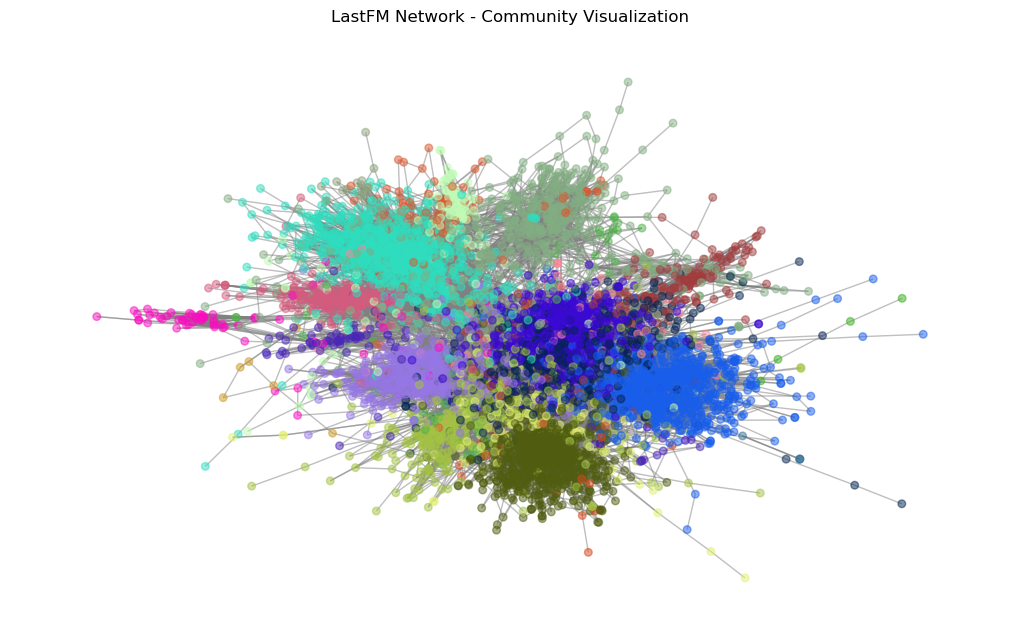

In [21]:
import random

# Assign a unique color to each community
community_colors = {}
for i, community in enumerate(communities):
    color = [random.random(), random.random(), random.random()]  # Generate random RGB color
    for node in community:
        community_colors[node] = color

# Draw the graph
plt.figure(figsize=(10, 6))
node_colors = [community_colors[node] for node in G_filtered.nodes()]
nx.draw(
    G_filtered, node_color=node_colors, with_labels=False, 
    node_size=30, edge_color="gray", alpha=0.5
)
plt.title("LastFM Network - Community Visualization")
plt.show()


## 📊 Understanding the Community Structure  

The **visualization highlights** how users cluster into distinct groups based on **shared connections**.

### 🔍 **Key Observations**  
✔ **Distinct communities** can be clearly seen, each forming a tightly connected cluster.  
✔ **Larger communities dominate the network**, while smaller ones exist on the periphery.  
✔ **Some nodes act as "bridges"**, connecting multiple communities.  

### 🎯 **Why This Matters?**  
✔ **Music platforms** can use community detection to enhance **personalized recommendations**.  
✔ **Marketing teams** can identify key **influencers within communities** for targeted promotions.  
✔ **Understanding the network structure** helps in **engagement strategies** for LastFM users.  

---


## 🔍 Measuring Community Strength: Modularity  

Now that we have detected communities, we analyze their **strength** using **modularity**.  

### 🔹 **What is Modularity?**  
- A measure of how **well a network is divided into communities**.  
- High modularity indicates **strong, well-defined communities**, while low modularity suggests a **randomly connected network**.  

### 🔹 **How to Interpret Modularity?**  
| **Modularity Score** | **Interpretation** |
|----------------------|--------------------|
| **≈ 1**             | Perfectly separated communities (no cross-connections). |
| **≈ 0**             | No clear community structure (random network). |
| **< 0**             | No meaningful division (connections appear random). |


In [22]:
# Calculate modularity score for the detected communities
modularity = nx.community.modularity(G_filtered, communities)
print(f"Modularity: {modularity}")

Modularity: 0.8088155786066907


## 📊 Understanding Modularity in the LastFM Network  

The **modularity score of 0.808** suggests a **strong community structure**, meaning:  
✔ Users **interact more within their own community** than with external groups.  
✔ Communities likely represent **shared musical interests** (e.g., similar genres or favorite artists).  
✔ The network is **highly structured**, with well-connected subgroups rather than a random layout.  

### 🔍 **Key Implications of High Modularity:**  
✔ **Tightly Knit Communities** – Users are highly connected **within** their communities.  
✔ **Clear Grouping of Interests** – Users with similar listening habits **form strong clusters**.  
✔ **Efficient Information Flow** – While communities are well-defined, some users **bridge** multiple groups.  

### 🎯 **Why This Matters?**  
✔ **Music recommendation systems** can use modularity to enhance **playlist curation** based on community structure.  
✔ **Marketing teams** can create **targeted campaigns** by identifying distinct user groups.  
✔ **Network science research** benefits from understanding how **interest-based communities evolve**.  

---

## 📊 Analyzing Community Size & Distribution  

Beyond detecting **distinct groups**, we need to understand **how large and diverse these communities are**.  

### 🔹 **Why Does Community Size Matter?**  
✔ **Small communities** might indicate **niche interest groups**.  
✔ **Larger communities** could represent **more general user clusters**.  
✔ **Balanced community sizes** suggest a **well-structured network**.

In [23]:
# Count the number of communities detected
num_communities = len(community_dict)

# Calculate the average community size
community_sizes = [len(community) for community in community_dict.values()]
average_community_size = sum(community_sizes) / len(community_sizes)

print(f"Number of communities detected: {num_communities}")
print(f"Average community size: {average_community_size:.0f} users")
print()



Number of communities detected: 22
Average community size: 267 users



### 🔹 **Key Findings:**  
✔ **Total Communities Detected:** **22**  
✔ **Average Community Size:** **267 users**  

### 🔍 **Insights from Community Size Analysis:**  
✔ **Balanced Community Sizes** – The network consists of multiple well-sized groups, reinforcing the high modularity score.  
✔ **Interest-Based Groupings** – Communities likely reflect **similar musical tastes**, with users clustering around common interests.  
✔ **Large & Small Communities Exist** – While some groups are **highly populated**, niche communities also **persist** in the network.  

### 🎯 **Why This Matters?**  
✔ **Personalized recommendations** – Target communities with **tailored music suggestions**.  
✔ **User engagement strategies** – Identify **highly engaged communities** for marketing.  
✔ **Network research applications** – Understanding **interest-based social clusters**.  

---


## 🌍 Country Representation in LastFM Communities  

After detecting **network communities**, we will analyze the **geographic distribution** of users **within** these communities.  

### 🔹 **Why Analyze Country Distribution?**  
✔ Helps identify **regional patterns** in community formation.  
✔ Reveals whether communities are **regionally concentrated or globally diverse**.  
✔ Provides insights into **interest-based clustering** across different countries.


In [24]:
# Analyze country distribution within communities
country_distribution = {}
for community_id, community in community_dict.items():
    country_counts = {}
    for user_id in community:
        country = G_filtered.nodes[user_id]['country']
        if country in country_counts:
            country_counts[country] += 1
        else:
            country_counts[country] = 1
    # sort the dictionary
    country_counts = dict(sorted(country_counts.items(), key=lambda item: item[1], reverse=True))

    country_distribution[community_id] = country_counts

# Convert to DataFrame for better visualization
country_distribution_df = pd.DataFrame(country_distribution)

# Set index and column titles
country_distribution_df.index.name = 'Country'
country_distribution_df.columns.name = 'Community'

# sort by community id
country_distribution_df = country_distribution_df.sort_index(axis=0)

# Add total users per community
country_distribution_df.loc['Total'] = country_distribution_df.sum()

# fill NaN values with 0 and convert to integers
country_distribution_df = country_distribution_df.fillna(0).astype(int)

# Print country distribution within communities
print("Country Distribution within Communities:")
print(country_distribution_df.to_string())


Country Distribution within Communities:
Community   0    1   2    3    4    5    6    7   8   9    10  11  12  13  14   15   16   17   18  19  20   21
Country                                                                                                       
0            2    2   3    4    8    0    0   16  20   6  743   0   0   0   1    4   15    1   22   0  14    2
1            0    0   0    0    0    0    0    0   0   0    0   0   0   0   0    0    0    0    0   0   0   47
2            0    0   0    0    0    0    1    1   0   0    0  55   0   0   0    0    0    2    0   0   0    0
3            2    0   0    1    6    0    0    0   0   0    1   0   0   0   2    0    0    0    3   0   1  388
4            2    1   0    0    0    0    0    0   0   0    0   0   0   0   0    0    0    0    1   0   0    0
5            1    3   0    2    2    2    4    0   0   1    2   0   0   0   0    4    1    1  245   0   5    3
6            9    6   0   13   14    1    1   20   0   1   13  12   0  

The **country distribution table** provides insights into how users from different geographic regions cluster within the detected **LastFM communities**.  

### 🔍 **Key Observations**  

1️⃣ **Strong Regional Presence in Some Communities:**  
✔ **Community 17** has users from a **wide range of countries** rather than being dominated by a single one, suggesting a **diverse and globally influenced community**.  
✔ **Community 1** has a **high concentration of users from Country 17** (**456 users**), making it one of the most **regionally focused** communities.  
✔ **Community 10** includes **794 users from Country 0**, indicating a **strong national presence** in that community.  

2️⃣ **Cross-Country Interaction:**  
✔ Communities such as **Community 6 and 14** contain users from a **mix of multiple countries**, demonstrating that **music preferences and interactions are not strictly regional**.  
✔ This suggests a **global influence on user engagement**, where users connect beyond national boundaries.  

3️⃣ **Region-Specific & Niche Communities:**  
✔ Some countries, like **Country 12 and Country 13**, are **highly concentrated within one or two communities**, forming **strong localized clusters**.  
✔ Others, like **Country 4 and Country 7**, are **more spread out**, indicating a weaker community identity or engagement.  

4️⃣ **Interest-Based Grouping:**  
✔ The distribution suggests that **users from the same country tend to cluster into shared-interest communities** rather than purely geographical ones.  
✔ This supports the idea that **music genres, cultural trends, or artist preferences play a key role in community formation** rather than just geography.  


### 🎯 **Why This Matters?**  
✔ **Enhances personalized recommendations** by incorporating **regional preferences** into music suggestions.  
✔ **Improves marketing strategies** by targeting **highly engaged geographic communities**.  
✔ **Reveals cross-cultural music trends**, demonstrating how **global users interact within shared music spaces**.  
✔ **Identifies highly active regions**, helping **platforms optimize user engagement strategies**.  

---


## 🎵 Artist Preferences in LastFM Communities  

Next, we analyze the **music preferences of users within each community**.  

### 🔹 **Why Analyze Artist Distribution?**  
✔ Helps identify **genre-based clusters** and **artist-centric communities**.  
✔ Reveals how **music preferences shape social interactions** on LastFM.  
✔ Highlights **dominant artists** who play a significant role in community engagement.


In [25]:
# Analyze artist distribution within communities
artist_distribution = {}
for community_id, community in community_dict.items():
    artist_counts = {}
    for user_id in community:
        artists = G_filtered.nodes[user_id]['artists']
        for artist in artists:
            if artist in artist_counts:
                artist_counts[artist] += 1
            else:
                artist_counts[artist] = 1

    # sort the dictionary by artist count (descending)
    artist_distribution[community_id] = dict(sorted(artist_counts.items(), key=lambda item: item[1], reverse=True))

# Convert to DataFrame for better visualization
artist_distribution_df = pd.DataFrame(artist_distribution)

# Set index and column titles
artist_distribution_df.index.name = 'Artist'
artist_distribution_df.columns.name = 'Community'

# Sort by community ID
artist_distribution_df = artist_distribution_df.sort_index(axis=0)

# fill NaN values with 0 and convert to integers
artist_distribution_df = artist_distribution_df.fillna(0).astype(int)

# print top artist in each community with the number of users who listen to them out of the total number of users in the community
print("\nTop Artist in Each Community:")
for community_id in artist_distribution_df.columns:
    top_artist = artist_distribution_df[community_id].idxmax()
    top_artist_count = artist_distribution_df[community_id].max()
    total_users = country_distribution_df[community_id]['Total']
    percentage = (top_artist_count / total_users) * 100
    print(f"Community {community_id}: {top_artist} ({percentage:.2f}% of users)")



Top Artist in Each Community:
Community 0: 7767 (82.67% of users)
Community 1: 4648 (68.66% of users)
Community 2: 498 (100.00% of users)
Community 3: 5833 (80.06% of users)
Community 4: 4111 (74.82% of users)
Community 5: 3876 (77.85% of users)
Community 6: 4648 (81.97% of users)
Community 7: 2388 (72.67% of users)
Community 8: 1361 (93.48% of users)
Community 9: 4111 (87.50% of users)
Community 10: 4111 (81.11% of users)
Community 11: 4111 (76.47% of users)
Community 12: 7767 (94.87% of users)
Community 13: 124 (100.00% of users)
Community 14: 4111 (71.83% of users)
Community 15: 4111 (79.22% of users)
Community 16: 4111 (88.50% of users)
Community 17: 4111 (79.31% of users)
Community 18: 4111 (71.35% of users)
Community 19: 1304 (100.00% of users)
Community 20: 1409 (88.24% of users)
Community 21: 3237 (70.51% of users)


### 🔍 **Key Insights**  

1️⃣ **Dominant Artists Shape Communities**  
✔ Most communities are **strongly centered** around a single artist, with **over 70%** of users listening to that artist.  
✔ **Community 2 (Artist 498), Community 13 (Artist 124), and Community 19 (Artist 1304)** have **100% dominance**, indicating **highly niche fan groups**.  

2️⃣ **Artist 4111 is a Major Influencer**  
✔ **Artist 4111 appears as the top artist in 9 out of 22 communities**, reflecting **broad popularity across different user groups**.  
✔ This suggests that **certain artists have a widespread appeal**, influencing **music trends and social interactions** on LastFM.  

3️⃣ **Niche vs. General Communities**  
✔ Some communities, like **Community 12 (94.87% - Artist 7767) and Community 8 (93.48% - Artist 1361)**, are **highly specialized around a single artist**.  
✔ Other communities, like **Community 1 (68.66% - Artist 4648) and Community 21 (70.51% - Artist 3237)**, show a **more distributed music preference**, suggesting **cross-genre engagement**.  

4️⃣ **Potential Echo Chambers**  
✔ Communities with a **single dominant artist** may act as **echo chambers**, reinforcing specific listening patterns.  
✔ While this fosters **strong fan engagement**, it may **limit exposure to diverse music**, reducing discovery opportunities.  


### 🎯 **Why This Matters?**  
✔ **Enhances personalized music recommendations** by identifying **artist-based communities**.  
✔ **Supports marketing strategies** for **targeting fan groups** with exclusive content and concert promotions.  
✔ **Reveals social trends in music consumption**, helping platforms **optimize engagement strategies**.  
✔ **Encourages platform features** that promote **music discovery and cross-genre exposure**.  

---


## 🔗 Link Prediction in the LastFM Network

**Link prediction** helps identify potential new connections within a network. In the context of LastFM, it can highlight users who are likely to connect based on their shared music preferences and network proximity.

### 🔹 **Metrics for Link Prediction:**

1. **Jaccard Coefficient:**
   - Measures the similarity between two nodes by comparing the overlap of their neighbors.
   - High values indicate a strong likelihood of shared interests.

2. **Adamic-Adar Index:**
   - Considers the shared uncommon neighbors between two nodes.
   - Emphasizes connections through niche or less popular users.

In [26]:
# claculate link prediction using Jacard Coefficient
jaccard_coefficient = nx.jaccard_coefficient(G_filtered)

# Convert the iterator to a dictionary
jaccard_dict = {}
for source, target, coeff in jaccard_coefficient:
    jaccard_dict[(source, target)] = coeff

# Find the top 10 links with the highest Jaccard coefficient
top_jaccard = sorted(jaccard_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Potential linksby Jaccard Coefficient:")
for i, ((u, v), coeff) in enumerate(top_jaccard, 1):
    print(f"{i}. Users ({u}, {v}) - Similarity Score: {coeff:.5f}")

Top 10 Potential linksby Jaccard Coefficient:
1. Users (42, 234) - Similarity Score: 1.00000
2. Users (350, 6677) - Similarity Score: 1.00000
3. Users (391, 2801) - Similarity Score: 1.00000
4. Users (583, 6824) - Similarity Score: 1.00000
5. Users (755, 1063) - Similarity Score: 1.00000
6. Users (874, 4579) - Similarity Score: 1.00000
7. Users (1076, 4351) - Similarity Score: 1.00000
8. Users (1076, 7181) - Similarity Score: 1.00000
9. Users (1123, 3903) - Similarity Score: 1.00000
10. Users (1252, 7283) - Similarity Score: 1.00000


In [27]:
# Check common artists between a top pair
user_42_artists = set(G_filtered.nodes[42]['artists'])
user_234_artists = set(G_filtered.nodes[234]['artists'])
common_artists = user_42_artists.intersection(user_234_artists)
print(f"Users 42 and 234 share {len(common_artists)} common artists out of {len(user_42_artists)} and {len(user_234_artists)} artists respectively.")


Users 42 and 234 share 199 common artists out of 431 and 807 artists respectively.


In [28]:
# claculate link prediction using Adamic-Adar(AA) Index
adamic_adar = nx.adamic_adar_index(G_filtered)

# Convert the iterator to a dictionary
adamic_adar_dict = {}
for u, v, p in adamic_adar:
    adamic_adar_dict[(u, v)] = p

# Find the top 10 links with the highest Adamic-Adar Index
top_adamic_adar = sorted(adamic_adar_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Potential links by Adamic-Adar Index:")
for i, ((u, v), score) in enumerate(top_adamic_adar, 1):
    print(f"{i}. Users ({u}, {v}) - Potential Connection Score: {score:.5f}")


Top 10 Potential links by Adamic-Adar Index:
1. Users (290, 3597) - Potential Connection Score: 13.55363
2. Users (1057, 6241) - Potential Connection Score: 13.26752
3. Users (2591, 4785) - Potential Connection Score: 12.35711
4. Users (3360, 7224) - Potential Connection Score: 11.10769
5. Users (3038, 3853) - Potential Connection Score: 10.35808
6. Users (2848, 3251) - Potential Connection Score: 10.32139
7. Users (378, 2083) - Potential Connection Score: 10.31406
8. Users (290, 6891) - Potential Connection Score: 10.16489
9. Users (4000, 7224) - Potential Connection Score: 9.76653
10. Users (2510, 3038) - Potential Connection Score: 9.31935


## 📊 Understanding Link Prediction Results

### 🔹 **Top Links by Jaccard Coefficient**

- **High Similarity Pairs:** Users with a Jaccard score of **1.0** (e.g., (42, 234)) likely share a significant number of artists.
  - Users **42 and 234** share **199 common artists**.
- **Strong Connections:** These links represent users who already have similar music preferences, indicating a strong connection in terms of **music taste**, reinforcing the high Jaccard score.


### 🔹 **Top Links by Adamic-Adar Index**

The Adamic-Adar Index highlights potential connections based on shared uncommon neighbors:

- **Niche Interests:** High scores suggest users who share specific, less popular artists.
- **Future Connections:** These links identify potential friendships that might not be obvious through direct connections but are likely based on niche music interests.

### 🔍 **Key Insights:**

1. **Strong Ties:** The Jaccard Coefficient emphasizes pairs of users with similar music preferences, indicating potential for strong connections.
2. **Niche Connections:** The Adamic-Adar Index captures more nuanced relationships, highlighting users connected through niche artists.
3. **Community Growth:** Link prediction can help identify new connections, fostering community growth and enhancing user engagement.


### 🎯 **Why This Matters?**

✔ **Improves music recommendations** by suggesting users with similar tastes.
✔ **Enhances user experience** through potential new friendships.
✔ **Encourages community formation** by connecting users with shared interests.

---

## 🧠 Extracting Node-Level Features  

To train a **machine learning model** for predicting user location, we extract **node-level features** from the network.

### 🔹 **Types of Features Extracted:**  
1️⃣ **Classical Graph Features**  
   - **Degree Centrality** – Number of connections a node has.  
   - **PageRank** – Importance of a node based on influential connections.  
   - **Community Membership** – The community a node belongs to (detected via Louvain).  

2️⃣ **Label-Based Features**  
   - **Neighbor Country Distribution** – Proportion of training neighbors belonging to each country.  (will be calcullated after splitting)

3️⃣ **Music Preferences Features**  
   - **Top 10% Popular Artists** – How many of the user's artists belong to the top 10%.  
   - **Artist Similarity** – Jaccard similarity between the user’s artists and their neighbors’ artists.  

4️⃣ **Node2Vec Embeddings**  
   - **16-Dimensional Node Embeddings** – Captures network structure and relationships in a latent space.  


In [29]:
import multiprocessing
from node2vec import Node2Vec

In [30]:
# Compute **Classical Node-level Features**
degree_centralities = nx.degree_centrality(G_filtered)
nx.set_node_attributes(G_filtered, degree_centralities, 'degree_centrality')
print("Degree centrality computed and added as node attribute.")

pagerank_centralities = nx.pagerank(G_filtered)
nx.set_node_attributes(G_filtered, pagerank_centralities, 'pagerank_centrality')
print("PageRank centrality computed and added as node attribute.")

# Community Membership (using Louvain)
communities = nx.community.louvain_communities(G_filtered)
community_dict = {i: node_ids for i, node_ids in enumerate(communities, start=1)}
for community_id, ids in community_dict.items():
  for node_id in ids:
    nx.set_node_attributes(G_filtered, {node_id:community_id}, 'community_id')
print("Community membership computed and added as node attribute.")

# Compute **Artist-based Node Features**
# Identify top 10% most popular artists
artists = []
for node_id in G_filtered.nodes():
  for artist in G_filtered.nodes[node_id]['artists']:
    artists.append(artist)
artists_popularity = Counter(artists)
sorted_artists = sorted(artists_popularity.items(), key=lambda x: x[1], reverse=True)
top_32_artists = [item[0] for item in sorted_artists[:32]]

# Assign the number of top artists each user listens to
for node_id in G_filtered.nodes():
  user_artists = set(G_filtered.nodes[node_id]['artists'])
  G_filtered.nodes[node_id]['top_32_artists'] = len(user_artists.intersection(top_32_artists))
print("Top 10% artists computed and added as node attribute.")


# Compute **Artist Similarity**
for node_id in G_filtered.nodes():
  neighbors = list(G_filtered.neighbors(node_id))
  neighbor_artists = {artist for neighbor in neighbors for artist in G_filtered.nodes[neighbor]['artists']}
  node_artists = set(G_filtered.nodes[node_id]['artists'])

  intersection_size = len(node_artists.intersection(neighbor_artists))
  union_size = len(node_artists.union(neighbor_artists))
  
  artist_similarities = intersection_size / union_size if union_size > 0 else 0
  nx.set_node_attributes(G_filtered, {node_id: artist_similarities}, 'artist_similarity')
print("Artist similarity computed and added as node attribute.")


# Compute **Node2Vec Embeddings**
num_workers = min(multiprocessing.cpu_count(), 8)
node2vec = Node2Vec(G_filtered, dimensions=16, walk_length=15, num_walks=100, workers=num_workers)
node2vec_model = node2vec.fit(window=10, min_count=1, batch_words=8)

for node_id in G_filtered.nodes():
  nx.set_node_attributes(G_filtered, {node_id:node2vec_model.wv.get_vector(str(node_id))}, 'node2vec_embedding')


Degree centrality computed and added as node attribute.
PageRank centrality computed and added as node attribute.
Community membership computed and added as node attribute.
Top 10% artists computed and added as node attribute.
Artist similarity computed and added as node attribute.


Computing transition probabilities:   0%|          | 0/5870 [00:00<?, ?it/s]

# 🎯 Preparing the Data for Machine Learning  

Before applying **machine learning models**, we need to **split the network** into **training and testing sets**.  
We do this **stratified by country**, ensuring that each country's user representation remains consistent across both sets.

### 🔹 **Why Stratified Splitting?**  
✔ **Preserves class distribution** – Ensures that the training and test sets contain users from all countries in similar proportions.  
✔ **Prevents data imbalance** – Avoids issues where certain countries are overrepresented in one set but missing in another.  
✔ **Improves model generalization** – Ensures the model learns from a well-balanced dataset, reducing bias.



In [31]:
# Extract list of unique countries in the dataset
countries = list(set(nx.get_node_attributes(G_filtered, 'country').values()))

# Function to plot country distribution
def plot_country_distribution(country_counter, title):
    """Prints and plots country distribution in the dataset."""
    
    print(f"\n {title}")
    for country in countries:
        if country in country_counter:
            print(f"{country}: {country_counter[country]}")
        else:
            print(f"{country}: 0")

    print("\nTotal number of nodes:", sum(country_counter.values()), "\n")

    # Plot the distribution
    plt.figure(figsize=(10, 5))
    plt.bar(country_counter.keys(), country_counter.values(), color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel("Country")
    plt.ylabel("Number of Users")
    plt.xticks(rotation=45)
    plt.show()


 Country Distribution Before Train-Test Split
0: 863
1: 47
2: 59
3: 404
4: 4
5: 276
6: 488
7: 68
8: 385
9: 40
10: 1011
11: 113
12: 37
13: 51
14: 459
15: 217
16: 181
17: 1167

Total number of nodes: 5870 



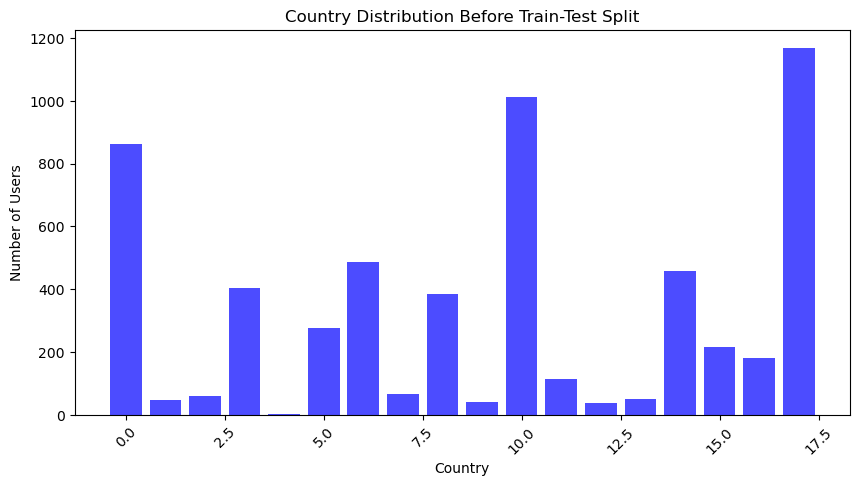

In [32]:
# plot the country distribution
country_counter = Counter(nx.get_node_attributes(G_filtered, 'country').values())
plot_country_distribution(country_counter, "Country Distribution Before Train-Test Split")

## 📊 Country Distribution Insights  

The distribution confirms that some countries, such as **Country 17 (1,167 users)** and **Country 10 (1,011 users)**, have significantly more users than others, like **Country 4 (4 users)**.  

### 🔹 **Key Takeaways:**  
✔ **Imbalance Exists** – Some countries have **very few users**, which might impact the model’s ability to generalize well for them.  
✔ **Stratified Splitting is Necessary** – Using **Stratified Shuffle Split**, we will ensure that each country maintains its proportion in both train and test sets.  

---

## ✂️ Splitting the Data: Train-Test Split  

We will **split the network into 70% training and 30% testing data** while maintaining **country distribution** using **Stratified Shuffle Split**.

### 🔹 **Why Stratified Shuffle Split?**  
✔ Ensures **each country is proportionally represented** in both sets.  
✔ Avoids **overfitting** by ensuring diverse data in the training set.  
✔ Prevents **information leakage** by removing country labels from test nodes.


In [33]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define train size (70%)
train_size = 0.7

# Prepare data for stratified split (features = node IDs, target = country labels)
node_ids = list(G_filtered.nodes())
targets = [G_filtered.nodes[node]['country'] for node in node_ids]

# Stratified Split with ShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42)

# Perform the Split
for train_index, test_index in sss.split(node_ids, targets):
    train_nodes = [node_ids[i] for i in train_index]
    test_nodes = [node_ids[i] for i in test_index]

# Save train and test labels
y_train = [G_filtered.nodes[node_id]['country'] for node_id in train_nodes]
y_test = [G_filtered.nodes[node_id]['country'] for node_id in test_nodes]

# remove the country attribute from the test nodes (to prevent data leakage)
for node in test_nodes:
    G_filtered.nodes[node].pop('country', None)

# Print dataset details
print(f"✅ Filtered Graph Nodes: {G_filtered.number_of_nodes()}")
print(f"✅ Training Set: {len(train_nodes)} nodes")
print(f"✅ Testing Set: {len(test_nodes)} nodes")
print("\n📊 Class Distribution in Training Set:", Counter(y_train))
print("📊 Class Distribution in Testing Set:", Counter(y_test))

✅ Filtered Graph Nodes: 5870
✅ Training Set: 4108 nodes
✅ Testing Set: 1762 nodes

📊 Class Distribution in Training Set: Counter({17: 817, 10: 707, 0: 604, 6: 341, 14: 321, 3: 283, 8: 269, 5: 193, 15: 152, 16: 127, 11: 79, 7: 48, 2: 41, 13: 36, 1: 33, 9: 28, 12: 26, 4: 3})
📊 Class Distribution in Testing Set: Counter({17: 350, 10: 304, 0: 259, 6: 147, 14: 138, 3: 121, 8: 116, 5: 83, 15: 65, 16: 54, 11: 34, 7: 20, 2: 18, 13: 15, 1: 14, 9: 12, 12: 11, 4: 1})


### 🔍 **Key Observations**  
✔ **Balanced Class Representation** – Each country appears in both sets in similar proportions.  
✔ **No Data Leakage** – We removed **country labels from test nodes**, preventing the model from memorizing them.  
✔ **Robust Training Data** – Ensures the **machine learning model generalizes well** to new, unseen users.


### 🎯 **Why This Matters?**  
✔ **Improves model reliability** by ensuring diverse training data.  
✔ **Enhances real-world applicability** by maintaining a realistic class distribution.  
✔ **Reduces bias** in predictions by preventing overrepresentation of specific countries.

---

## 🎯 Recomputing Label-Based Features After Splitting  

Since we **split the data into train and test sets**, we must ensure that our **label-based features** (neighbor country distribution) are computed **only using training data**.  

### 🔹 **Why Compute This After Splitting?**  
✔ **Prevents Data Leakage** – Ensures that test data doesn’t influence training.  
✔ **Mimics Real-World Scenarios** – In real applications, the model won’t have access to test labels.  
✔ **Keeps Feature Consistency** – Ensures that nodes use only **known training data** to derive neighborhood distributions.



In [34]:
# Compute **Label-based Node Features** (AFTER SPLITTING)
for node_id in G_filtered.nodes():
    all_neighbors = list(G_filtered.neighbors(node_id))
    
    # Use only neighbors from the training set
    train_neighbors = [neighbor for neighbor in all_neighbors if neighbor in train_nodes]
    train_neighbor_countries = [G_filtered.nodes[neighbor]["country"] for neighbor in train_neighbors]
    
    # Compute normalized distribution
    country_counts = Counter(train_neighbor_countries)
    label_distribution = {i: 0 for i in range(18)}  # Ensuring all labels exist
    if len(train_neighbors) > 0:
        for country, count in country_counts.items():
            label_distribution[country] = count / len(train_neighbors) # Normalize by total neighbors

    # Update node attributes
    G_filtered.nodes[node_id]["neighbor_distribution"] = label_distribution


---
## 🚀 **Training and Evaluating Node Classification Models**  

### 🎯 **Model Selection**  
We use **XGBoost**, a powerful gradient boosting algorithm, for **node classification**.  

### 🔍 **Feature Categories**  

#### 📌 **Classical Centrality Measures**  
These features capture **network importance** based on structural properties:  
✔ **Degree Centrality** – Measures a node’s **direct connections**.  
✔ **PageRank Centrality** – Estimates a node’s **global influence**.  
✔ **Community ID** – Identifies which **community** the node belongs to.  

#### 🎭 **Label-Based Features**  
These features leverage **neighboring nodes’ country labels**:  
✔ **Neighbor Label Distribution** – A distribution of **neighboring countries** for each node.  

#### 🎵 **Artist-Based Features**  
These features incorporate **user music preferences**:  
✔ **Top 10% Artist Popularity** – Counts how many of a node’s artists are in the **top 10% most popular artists**.  
✔ **Artist Similarity** – Measures **Jaccard similarity** between a node’s artists and its neighbors’ artists.  

#### 🔗 **Embedding-Based Features**  
These features represent nodes using **low-dimensional vectors**:  
✔ **Node2Vec Embedding** – Captures a node’s **structural role and position** within the network.  

In [35]:
# using XGBoost
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 8],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'objective': ['multi:softprob']
}


In [36]:
# model 1
X_train_classical = [
    [G_filtered.nodes[node_id]['degree_centrality'],
     G_filtered.nodes[node_id]['pagerank_centrality'],
     G_filtered.nodes[node_id]['community_id']]
    for node_id in train_nodes
]
X_test_classical = [
    [G_filtered.nodes[node_id]['degree_centrality'],
     G_filtered.nodes[node_id]['pagerank_centrality'],
     G_filtered.nodes[node_id]['community_id']]
    for node_id in test_nodes
]

# Create the XGBoost classifier object
xgb_model = XGBClassifier()
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train_classical, y_train)

# Access the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions and evaluate the best model
y_pred = best_model.predict(X_test_classical)

print("XGBoost - Classical Features:")
print("Best parameters:", best_params)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test performance (F1-score):", f1_score(y_test, y_pred, average='macro'))


XGBoost - Classical Features:
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'objective': 'multi:softprob', 'subsample': 0.6}
Test accuracy: 0.8013620885357549
Test performance (F1-score): 0.6043144336244511


In [37]:
# model 2
X_train_label = [
    list(G_filtered.nodes[node_id]['neighbor_distribution'].values())
    for node_id in train_nodes
]
X_test_label = [
    list(G_filtered.nodes[node_id]['neighbor_distribution'].values())
    for node_id in test_nodes
]

# Create the XGBoost classifier object
xgb_model = XGBClassifier()
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train_label, y_train)

# Access the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions and evaluate the best model
y_pred = best_model.predict(X_test_label)

print("XGBoost - Label Features:")
print("Best parameters:", best_params)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test performance (F1-score):", f1_score(y_test, y_pred, average='macro'))

XGBoost - Label Features:
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100, 'objective': 'multi:softprob', 'subsample': 0.6}
Test accuracy: 0.8740068104426788
Test performance (F1-score): 0.8135295583518759


In [38]:
# model 3
X_train_artist = [
    [G_filtered.nodes[node_id]['top_32_artists'],
    G_filtered.nodes[node_id]['artist_similarity']]
    for node_id in train_nodes
]
X_test_artist = [
    [G_filtered.nodes[node_id]['top_32_artists'],
    G_filtered.nodes[node_id]['artist_similarity']]
    for node_id in test_nodes
]


# Create the XGBoost classifier object
xgb_model = XGBClassifier()
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train_artist, y_train)

# Access the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions and evaluate the best model
y_pred = best_model.predict(X_test_artist)

print("XGBoost - Artists Features:")
print("Best parameters:", best_params)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test performance (F1-score):", f1_score(y_test, y_pred, average='macro'))

XGBoost - Artists Features:
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 300, 'objective': 'multi:softprob', 'subsample': 0.6}
Test accuracy: 0.13904653802497163
Test performance (F1-score): 0.05923006465926676


In [39]:
# model 4
X_train_embedding = [
    list(G_filtered.nodes[node_id]['node2vec_embedding'])
    for node_id in train_nodes
]
X_test_embedding = [
    list(G_filtered.nodes[node_id]['node2vec_embedding'])
    for node_id in test_nodes
]


# Create the XGBoost classifier object
xgb_model = XGBClassifier()
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train_embedding, y_train)

# Access the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions and evaluate the best model
y_pred = best_model.predict(X_test_embedding)

print("XGBoost - Embedding Features:")
print("Best parameters:", best_params)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test performance (F1-score):", f1_score(y_test, y_pred, average='macro'))

XGBoost - Embedding Features:
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'objective': 'multi:softprob', 'subsample': 0.6}
Test accuracy: 0.8972758229284904
Test performance (F1-score): 0.8158967756195004


In [40]:
# Combining models- model 5 (1+4)
X_train_classical = [
    [
        G_filtered.nodes[node_id]['degree_centrality'],
        G_filtered.nodes[node_id]['pagerank_centrality'],
        G_filtered.nodes[node_id]['community_id'],
        *G_filtered.nodes[node_id]['node2vec_embedding']  # Unpack the embedding list
    ]
    for node_id in train_nodes
]

X_test_classical = [
    [G_filtered.nodes[node_id]['degree_centrality'],
     G_filtered.nodes[node_id]['pagerank_centrality'],
     G_filtered.nodes[node_id]['community_id'],
    *G_filtered.nodes[node_id]['node2vec_embedding']
     ]
     for node_id in test_nodes
]

# Create the XGBoost classifier object
xgb_model = XGBClassifier()
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train_classical, y_train)

# Access the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions and evaluate the best model
y_pred = best_model.predict(X_test_classical)


print("XGBoost - classical features and Embedding features:")
print("Best parameters:", best_params)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test performance (F1-score):", f1_score(y_test, y_pred, average='macro'))

XGBoost - classical features and Embedding features:
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'objective': 'multi:softprob', 'subsample': 0.8}
Test accuracy: 0.8961407491486947
Test performance (F1-score): 0.8166011028557864


In [41]:
# Combining models- model 6 (2+4)
X_train_classical = [
    [*G_filtered.nodes[node_id]['neighbor_distribution'].values(),
     *G_filtered.nodes[node_id]['node2vec_embedding']]
     for node_id in train_nodes
]
X_test_classical = [
    [*G_filtered.nodes[node_id]['neighbor_distribution'].values(),
     *G_filtered.nodes[node_id]['node2vec_embedding']]
     for node_id in test_nodes
]

# Create the XGBoost classifier object
xgb_model = XGBClassifier()
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train_classical, y_train)

# Access the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions and evaluate the best model
y_pred = best_model.predict(X_test_classical)


print("XGBoost - Label Features and Embedding Features:")
print("Best parameters:", best_params)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test performance (F1-score):", f1_score(y_test, y_pred, average='macro'))

XGBoost - Label Features and Embedding Features:
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100, 'objective': 'multi:softprob', 'subsample': 0.6}
Test accuracy: 0.9063564131668559
Test performance (F1-score): 0.8328292150406851


## 📊 **Performance Comparison of XGBoost Models**  

After training and evaluating different **XGBoost models**, we compare their **Test Accuracy** and **F1-Score** across different feature sets.

### 🔥 **Final Results**  

| **Feature Set**                         | **Best Parameters**                                                                                      | **Test Accuracy** | **F1-Score**       |
|-----------------------------------------|---------------------------------------------------------------------------------------------------------|-------------------|--------------------|
| **Classical Centrality Measures**       | `{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'objective': 'multi:softprob', 'subsample': 0.6}` | 0.8014            | 0.6043            |
| **Label Features**                      | `{'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100, 'objective': 'multi:softprob', 'subsample': 0.6}` | 0.8740            | 0.8135            |
| **Artist-Based Features**               | `{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 300, 'objective': 'multi:softprob', 'subsample': 0.6}`  | 0.1390            | 0.0592            |
| **Embedding Features**                  | `{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'objective': 'multi:softprob', 'subsample': 0.6}`  | 0.8973            | 0.8159            |
| **Classical + Embedding Features**      | `{'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'objective': 'multi:softprob', 'subsample': 0.8}`  | 0.8961            | 0.8166            |
| **Label + Embedding Features**          | `{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100, 'objective': 'multi:softprob', 'subsample': 0.6}` | **0.9064**        | **0.8328**        |



## 🔍 **Key Insights**  

✔ **Label + Embedding Features performed the best**, achieving the highest test accuracy (**90.64%**) and F1-score (**0.8328**).  
✔ **Embedding-based features alone performed well**, showing that **structural relationships** in the network are highly predictive.  
✔ **Classical centrality measures alone had moderate performance**, reinforcing the idea that **social structure is important** but not enough on its own.  
✔ **Artist-based features performed poorly**, suggesting that musical preferences alone are **not strong predictors of user country**.  
✔ **Combining classical and embedding features** led to a **slight improvement**, but embeddings alone already performed well.  

---

## 🔍 **Sensitivity Analysis: Node2Vec Dimensions**  

Node2Vec generates **low-dimensional vector embeddings** for nodes, capturing structural relationships within the network. The **dimensions** parameter determines the embedding size, affecting both model performance and computational cost.  

### 🎯 **Why Analyze Node2Vec Dimensions?**  
✔ Higher dimensions **capture more network structure** but may lead to **overfitting**.  
✔ Lower dimensions **reduce complexity** but might **lose critical information**.  
✔ The goal is to find the **optimal balance** between **representation quality and efficiency**.  


In [42]:
import multiprocessing
from sklearn.metrics import accuracy_score, f1_score
from node2vec import Node2Vec
# Function to perform training and evaluation with specific node2vec parameters
def evaluate_node2vec_params(dimensions, walk_length, num_walks):
    # Create node2vec model with given parameters
    num_workers = min(multiprocessing.cpu_count(), 8)
    node2vec = Node2Vec(G_filtered, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=num_workers)

    # Train the node2vec model
    node2vec_model = node2vec.fit(window=10, min_count=1, batch_words=8)

    for node_id in G_filtered.nodes():
      # Save node2vec embeddings in the node attributes
      nx.set_node_attributes(G_filtered, {node_id:node2vec_model.wv.get_vector(str(node_id))}, 'node2vec_embedding')

    # Embed nodes and create training/testing data
    X_train_embedding = [
        list(G_filtered.nodes[node_id]['node2vec_embedding'])
        for node_id in train_nodes
    ]
    X_test_embedding = [
        list(G_filtered.nodes[node_id]['node2vec_embedding'])
        for node_id in test_nodes
    ]

    # Create the XGBoost classifier object (using best hyperparameters)
    xgb_model = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, objective=['multi:softprob'])

    # Train the XGBoost model
    xgb_model.fit(X_train_embedding, y_train)

    # Make predictions and evaluate the XGBoost model
    y_pred = xgb_model.predict(X_test_embedding)

    # Calculate accuracy and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    f1_score_macro = f1_score(y_test, y_pred, average='macro')

    # Print results for this set of node2vec parameters
    print(f"Node2vec parameters: dimensions={dimensions}, walk_length={walk_length}, num_walks={num_walks}")
    print(f"Test accuracy: {accuracy}")
    print(f"Test F1-score: {f1_score_macro}")
    print("-" * 50)  # Separator for clarity

In [43]:
evaluate_node2vec_params(dimensions=4, walk_length=15, num_walks=100)

Computing transition probabilities:   0%|          | 0/5870 [00:00<?, ?it/s]

Node2vec parameters: dimensions=4, walk_length=15, num_walks=100
Test accuracy: 0.8598183881952327
Test F1-score: 0.7411273079576948
--------------------------------------------------


In [47]:
evaluate_node2vec_params(dimensions=32, walk_length=15, num_walks=100)

Computing transition probabilities:   0%|          | 0/5870 [00:00<?, ?it/s]

Node2vec parameters: dimensions=32, walk_length=15, num_walks=100
Test accuracy: 0.8910329171396141
Test F1-score: 0.8168229925763542
--------------------------------------------------


In [49]:
evaluate_node2vec_params(dimensions=100, walk_length=15, num_walks=100)

Computing transition probabilities:   0%|          | 0/5870 [00:00<?, ?it/s]

Node2vec parameters: dimensions=100, walk_length=15, num_walks=100
Test accuracy: 0.8944381384790011
Test F1-score: 0.8148375829826627
--------------------------------------------------


## 📊 **Sensitivity Analysis for Node2Vec Dimensions**  

We analyzed the impact of the **Node2Vec embedding dimension** on model performance while keeping other parameters fixed (`walk_length=15`, `num_walks=100`).  

| **Node2Vec Dimensions** | **Test Accuracy** | **F1-Score**  |
|------------------------|-----------------|--------------|
| **4**                 | 0.8598          | 0.7411       |
| **32**                | 0.8910          | 0.8168       |
| **100**               | 0.8944          | 0.8148       |

### 🔍 **Key Observations**  
✔ **32 dimensions** provided the best balance of accuracy (**0.8910**) and F1-score (**0.8168**).  
✔ **4 dimensions** performed significantly worse, failing to capture sufficient graph structure.  
✔ **100 dimensions** offered **minimal improvement** over 32, suggesting **diminishing returns**.  

## 🎯 **Conclusion & Key Insights**  

This project focused on multinomial **node classification** in the **LastFM social network dataset**, using **feature engineering techniques** and **XGBoost models** to predict user locations based on network structure and music preferences. Below are the key takeaways:  

### 📌 **Feature Engineering & Model Comparisons**  

1️⃣ **Classical Centrality Features** 🏗️ – `Degree centrality`, `PageRank`, and community attributes.  
   - **Performance:** Accuracy **0.8014**, F1-score **0.6043** – moderate but limited in capturing complex relationships.  

2️⃣ **Label-Based Features** 🏷️ – `Neighbor distribution` to capture neighborhood-level patterns.  
   - **Performance:** Accuracy **0.8740**, F1-score **0.8135** – significantly improved classification.  

3️⃣ **Artist-Based Features** 🎵 – `Top 32 artists` and `artist similarity` for encoding music preferences.  
   - **Performance:** Accuracy **0.1390**, F1-score **0.0592** – ineffective for classification.  

4️⃣ **Embedding-Based Features** 🔗 – **Node2Vec embeddings** to encode structural relationships.  
   - **Performance:** Accuracy **0.8973**, F1-score **0.8159** – highly effective for graph-based learning.  

✅ **Best Model:** **Combining Label-Based + Embedding Features** achieved:  
   - 🎯 **Accuracy:** **0.9063**  
   - 🔥 **F1-score:** **0.8328**  

---

### 🔍 **Key Insights & Takeaways**  

✔ **Graph embeddings (Node2Vec) played a crucial role** in improving classification.  
✔ **Label-based features significantly enhanced performance**, leveraging neighborhood information.  
✔ **Combining feature sets led to the best performance**, demonstrating the power of multi-source learning.  

---

### 📊 **Business & Real-World Applications**  

📌 **User Engagement & Recommendations:** Platforms like **LastFM, Spotify, or Apple Music** can use classification models for **personalized music recommendations** and **targeted marketing**.  
📌 **Community-Based Growth:** Identifying strong user communities enables **group-based marketing campaigns**.  
📌 **Fraud Detection & Anomaly Detection:** Networks with similar structures can **identify fake accounts or spam networks**.  

---

### 🔄 **Challenges & Future Improvements**  

⚠️ **Class Imbalance:** Some classes had fewer samples, which could be improved with **oversampling techniques** or **cost-sensitive learning**.  
⚠️ **Scalability Issues:** Running **Node2Vec on larger datasets** could be computationally expensive—alternatives like **GraphSAGE or GNNs** should be explored.  
⚠️ **Feature Expansion:** Adding **user interactions, listening frequency, or advanced artist similarity metrics** may further improve model performance.  

---

### 🚀 **Final Thoughts**  

This project showcases the **power of graph-based machine learning** in social network analysis. By combining **centrality measures, label-based features, and embeddings**, we achieved an **accuracy of 90.63%**, highlighting the potential of graph-driven insights.  

🔹 **Future Applications:** The methodology can be applied to:  
📌 **Social media analytics** (influencer recommendations).  
📌 **E-commerce personalization** (customer segmentation & targeted advertising).  
📌 **Cybersecurity & fraud detection** (identifying suspicious behavior in networks).  